In [106]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
validation_split_seed = 3

In [107]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle

In [108]:
def load_data():
    with open("htt_features.pkl", "rb") as input:
        legs, jets, global_params, properties =pickle.load(input)
    print("no of legs: ", len(legs))
    print("no of jets: ", len(jets))
    print("params: ", global_params.keys(), properties.keys())
load_data()

('no of legs: ', 2)
('no of jets: ', 0)
('params: ', ['covMET10', 'genMass', 'covMET11', 'higgsPT', 'higgsMassTrans', 'visMass', 'covMET00', 'covMET01'], ['leg_2_PDGId', 'leg_1_PDGId', 'leg_2_decayMode'])


In [111]:
to_predict = "genMass"

In [112]:
#preparing flat data and target numpy arrays
def prepare_data():
    data = []
    def add_legs():
        for leg in legs:
            for prop in leg:
                data.append(prop)
    def add_jets():
        for leg in jets:
            for prop in leg:
                data.append(prop)
    def add_globals(labels):
        for key in global_params:
            if key!=to_predict and key in labels:
                data.append(global_params[key])
    def add_properties(labels):
        for key in properties:
            if key!=to_predict and key in labels:
                data.append(properties[key])
    add_legs()
    add_jets()
    add_globals(global_params.keys())
    add_properties(properties.keys())
    data = np.array(data)
    data = np.transpose(data)
    
    if to_predict in global_params.keys(): target = np.array(global_params[to_predict])
    elif to_predict in properties.keys(): target = np.array(properties[to_predict])
    else:
        raise ValueError("`to_predict`: (" + to_predict + ") does not match any key")
    target = np.transpose(target)
    print("data.shape : ", data.shape)
    print("target.shape : ", target.shape)
    return data, target
data, target = prepare_data()

('data.shape : ', (66583, 18))
('target.shape : ', (66583,))


In [113]:
#splitting data between train and validation set
x_train, x_val, y_train, y_val = train_test_split(data, target, train_size=0.9, random_state=validation_split_seed)

In [116]:
#model definition
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(128, input_dim = data.shape[1], activation="relu"))
    model.add(tf.keras.layers.Dense(64, input_dim = data.shape[1], activation="linear"))
    model.add(tf.keras.layers.Dense(32, input_dim = data.shape[1], activation="linear"))
    model.add(tf.keras.layers.Dense(1, activation="linear"))
    # beta1 is decay added to improve stability
    model.compile(optimizer=tf.train.AdamOptimizer(beta1=0.99),
                  loss='mse')
    print(model.summary())
    return model

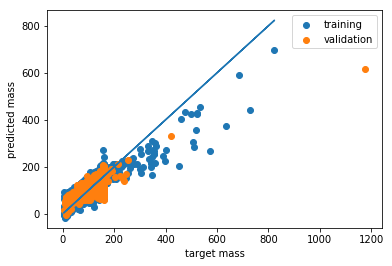

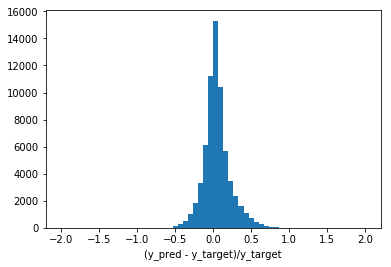

In [171]:
def plot_preds(x_train, x_val, y_train, y_val):
    y_train_pred = model.predict(x_train)
    plt.scatter(y_train,y_train_pred, label="training")
    y_val_pred = model.predict(x_val)
    plt.scatter(y_val,model.predict(x_val), label="validation")
    plt.plot(y_train, y_train)
    plt.legend()
    plt.xlabel("target mass")
    plt.ylabel("predicted mass")
    plt.show()
    
    y_pred = np.concatenate((y_train_pred, y_val_pred), axis=0)[:,0]
    y_all = np.concatenate((y_train, y_val), axis=0)
    error = (y_pred - y_all)/y_all
    plt.hist(error, bins=60, range=(-2,2))
    plt.xlabel("(y_pred - y_target)/y_target")
    plt.show()
plot_preds(x_train, x_val, y_train, y_val)

In [164]:
history = np.empty((2,0))
def clean_history():
    global history
    history = np.empty((2,0))
def update_history(h):
    global history
    history = np.append(history, [h.history['loss'], h.history['val_loss']],axis=1)
def plot_history():
    plt.plot(history[0], label='train')
    plt.plot(history[1], label='validation')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [160]:
a= history.shape
update_history(h)
a,history.shape

((2, 6), (2, 9))

In [162]:
h = model.fit(x=x_train, y=y_train, epochs=3, verbose=1, batch_size=64, callbacks=None, validation_data=(x_val,y_val))
update_history(h)

Train on 59924 samples, validate on 6659 samples
Epoch 1/3
59924/59924 [==============================] - 2s 35us/step - loss: 389.4220 - val_loss: 436.7786
Epoch 2/3
59924/59924 [==============================] - 2s 35us/step - loss: 386.6758 - val_loss: 410.1063
Epoch 3/3
59924/59924 [==============================] - 2s 35us/step - loss: 392.5226 - val_loss: 409.7462


In [166]:
plot_steps = 10
epochs_per_plot_step = 5

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 128)               2432      
_________________________________________________________________
dense_53 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_54 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 33        
Total params: 12,801
Trainable params: 12,801
Non-trainable params: 0
_________________________________________________________________
None
Train on 59924 samples, validate on 6659 samples
Epoch 1/5
59924/59924 [==============================] - 3s 50us/step - loss: 961.8809 - val_loss: 580.1678
Epoch 2/5
59924/59924 [==============================] - 3s 42us/step - loss: 540.4647 - val_loss: 560.6637


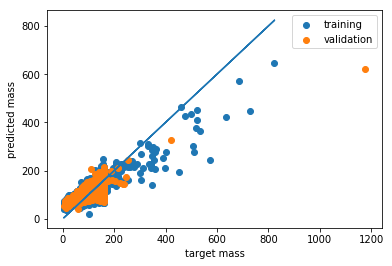

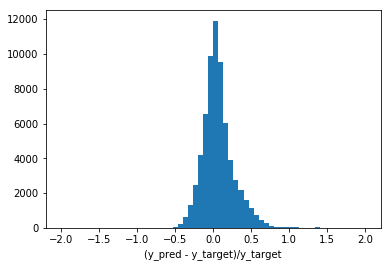

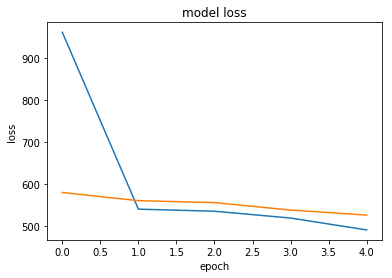

Train on 59924 samples, validate on 6659 samples
Epoch 1/5
59924/59924 [==============================] - 2s 41us/step - loss: 470.7082 - val_loss: 487.0027
Epoch 2/5
59924/59924 [==============================] - 2s 35us/step - loss: 464.8910 - val_loss: 557.6296
Epoch 3/5
59924/59924 [==============================] - 2s 36us/step - loss: 459.2755 - val_loss: 478.3177
Epoch 4/5
59924/59924 [==============================] - 2s 40us/step - loss: 448.7089 - val_loss: 461.5005
Epoch 5/5
59924/59924 [==============================] - 3s 42us/step - loss: 429.7420 - val_loss: 448.6979


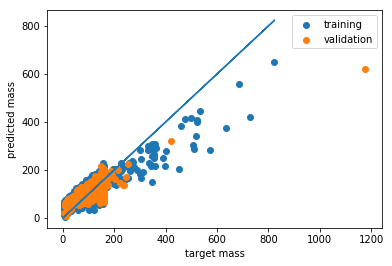

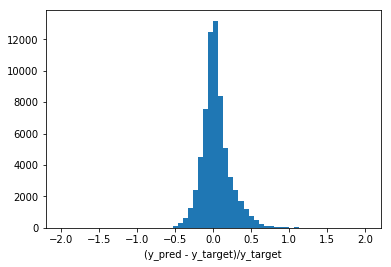

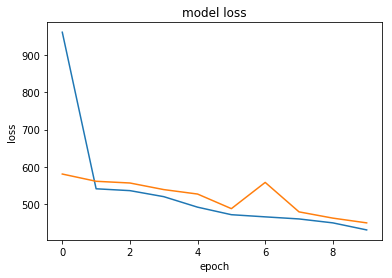

Train on 59924 samples, validate on 6659 samples
Epoch 1/5
59924/59924 [==============================] - 2s 39us/step - loss: 430.9374 - val_loss: 453.8857
Epoch 2/5
59924/59924 [==============================] - 2s 37us/step - loss: 419.1626 - val_loss: 431.1277
Epoch 3/5
59924/59924 [==============================] - 2s 37us/step - loss: 409.7207 - val_loss: 443.6580
Epoch 4/5
59924/59924 [==============================] - 2s 37us/step - loss: 404.0245 - val_loss: 442.7834
Epoch 5/5
59924/59924 [==============================] - 2s 37us/step - loss: 401.5103 - val_loss: 433.1747


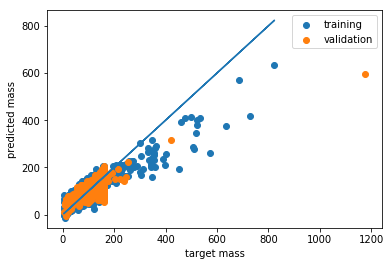

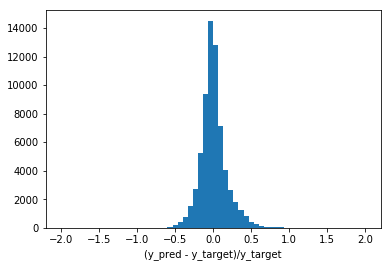

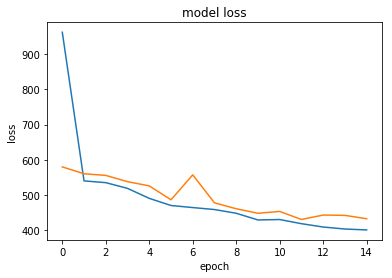

Train on 59924 samples, validate on 6659 samples
Epoch 1/5
59924/59924 [==============================] - 2s 38us/step - loss: 399.4469 - val_loss: 433.1910
Epoch 2/5
59924/59924 [==============================] - 2s 37us/step - loss: 391.5232 - val_loss: 426.4626
Epoch 3/5
59924/59924 [==============================] - 2s 37us/step - loss: 390.8205 - val_loss: 426.6119
Epoch 4/5
59924/59924 [==============================] - 2s 36us/step - loss: 390.0445 - val_loss: 442.8100
Epoch 5/5
59924/59924 [==============================] - 2s 37us/step - loss: 386.9750 - val_loss: 427.3830


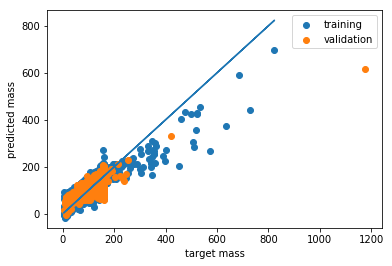

KeyboardInterrupt: 

In [167]:
model = get_model()
clean_history()
for plot_step in range(plot_steps):
    h = model.fit(x=x_train, y=y_train, epochs=epochs_per_plot_step, verbose=1, batch_size=64, callbacks=None, validation_data=(x_val,y_val))
    plot_preds(x_train, x_val, y_train, y_val)
    update_history(h)
    plot_history()